
# Model Monitoring — Trend Dashboard

This notebook loads **monthly monitoring Parquet files** produced by the monitoring job and visualizes key trends.
It expects files like:

- `datamart/gold/model_monitoring/monthly/monitor_YYYY_MM_01.parquet` (per-month)
- Optionally: consolidated window parquet (e.g., `monitor_window_*.parquet`)

In [56]:
# ==== Configuration ====
BASE_DIR = Path(".").resolve()

MONITOR_ROOT = BASE_DIR.parent / "datamart" / "gold" / "model_monitoring"
MONTHLY_DIR  = f"{MONITOR_ROOT}/monthly"                  # folder containing monitor_YYYY_MM_01.parquet

# Optional: set to a specific consolidated parquet path; leave as None to skip
CONSOLIDATED_PATH = None  # e.g., f"{MONITOR_ROOT}/monitor_window_2024-01-01_to_2024-12-01.parquet"

# AUC thresholds (reference lines). Adjust for your project.
AUC_CAUTION = 0.70
AUC_GOOD    = 0.75

print("MONITOR_ROOT:", MONITOR_ROOT)
print("MONTHLY_DIR :", MONTHLY_DIR)
print("CONSOLIDATED_PATH:", CONSOLIDATED_PATH)
print("AUC thresholds:", AUC_CAUTION, AUC_GOOD)

MONITOR_ROOT: /app/scripts/datamart/gold/model_monitoring
MONTHLY_DIR : /app/scripts/datamart/gold/model_monitoring/monthly
CONSOLIDATED_PATH: None
AUC thresholds: 0.7 0.75


In [57]:
import os, glob
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def _coerce_datetime(s):
    try:
        return pd.to_datetime(s)
    except Exception:
        return pd.to_datetime(s, errors="coerce")

def _load_monthly_parquets(monthly_dir: str) -> pd.DataFrame:
    paths = sorted(glob.glob(os.path.join(monthly_dir, "monitor_*.parquet")))
    if not paths:
        raise FileNotFoundError(f"No monthly monitor_*.parquet files found in: {monthly_dir}")
    dfs = []
    for p in paths:
        try:
            df = pd.read_parquet(p)
            dfs.append(df)
        except Exception as e:
            print("[WARN] Could not read", p, "->", e)
    if not dfs:
        raise RuntimeError("No readable monthly parquet files.")
    m = pd.concat(dfs, ignore_index=True)
    # Normalize columns that might be strings
    if "month" in m.columns:
        m["month"] = _coerce_datetime(m["month"]).dt.to_period("M").dt.to_timestamp()
    # Standardize likely metric column names to a canonical set if needed
    rename_map = {
        "predicted_default_risk_mean": "score_mean",
        "macro_f1": "f1_macro",
        "weight_f1": "f1_weighted",
        "auc": "auc_roc"
    }
    for k, v in rename_map.items():
        if k in m.columns and v not in m.columns:
            m[v] = m[k]
    # sort
    m = m.sort_values("month").reset_index(drop=True)
    return m

def _plot_line(df, x, y, title, ylabel, hlines=None, outfile=None):
    # Each chart in its own figure; do not set colors or styles.
    plt.figure(figsize=(9,4.5))
    plt.plot(df[x], df[y], marker="o")
    if hlines:
        for yv, lbl in hlines:
            plt.axhline(y=yv, linestyle="--")
            plt.text(df[x].iloc[0], yv, f" {lbl}", va="bottom")
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(ylabel)
    plt.grid(True)
    if outfile:
        Path(outfile).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(outfile, bbox_inches="tight")
    plt.show()

In [58]:

monthly = _load_monthly_parquets(MONTHLY_DIR)

# If a consolidated path is given, try loading it (optional)
consolidated = None
if CONSOLIDATED_PATH and Path(CONSOLIDATED_PATH).exists():
    try:
        consolidated = pd.read_parquet(CONSOLIDATED_PATH)
        if "month" in consolidated.columns:
            consolidated["month"] = _coerce_datetime(consolidated["month"]).dt.to_period("M").dt.to_timestamp()
        consolidated = consolidated.sort_values("month").reset_index(drop=True)
        print("Loaded consolidated:", CONSOLIDATED_PATH)
    except Exception as e:
        print("[WARN] Could not read consolidated parquet:", e)

print("Monthly rows:", len(monthly))
monthly.tail(3)


Monthly rows: 10


,month,model_selector,model_uri,sample_size,score_min,score_max,score_mean,score_std,accuracy,precision,recall,f1_macro,f1_weighted,auc_roc,ks_vs_trailing,psi_vs_trailing
7,2024-10-01,None,None,513,0.002111,0.981986,0.276111,None,0.875244,0.809524,0.718310,0.838381,0.872836,0.925212,0.043358,0.023319
8,2024-11-01,None,None,491,0.001584,0.984644,0.292452,None,0.867617,0.823077,0.718121,0.837282,0.864898,0.934946,0.033550,0.037954
9,2024-12-01,None,None,498,0.003517,0.979292,0.280059,None,0.885542,0.908333,0.703226,0.856835,0.881037,0.958996,0.050177,0.012126


In [59]:

summary = {
    "coverage_months": int(monthly["month"].nunique() if "month" in monthly else 0),
    "first_month": str(monthly["month"].min()) if "month" in monthly and len(monthly) else None,
    "last_month":  str(monthly["month"].max()) if "month" in monthly and len(monthly) else None,
    "avg_sample_size": float(pd.to_numeric(monthly.get("sample_size", pd.Series(dtype=float)), errors="coerce").dropna().mean()) if "sample_size" in monthly else None,
    "avg_score_mean": float(pd.to_numeric(monthly.get("score_mean", pd.Series(dtype=float)), errors="coerce").dropna().mean()) if "score_mean" in monthly else None,
    "avg_accuracy": float(pd.to_numeric(monthly.get("accuracy", pd.Series(dtype=float)), errors="coerce").dropna().mean()) if "accuracy" in monthly else None,
    "avg_f1_macro": float(pd.to_numeric(monthly.get("f1_macro", pd.Series(dtype=float)), errors="coerce").dropna().mean()) if "f1_macro" in monthly else None,
    "avg_auc_roc": float(pd.to_numeric(monthly.get("auc_roc", pd.Series(dtype=float)), errors="coerce").dropna().mean()) if "auc_roc" in monthly else None,
    "avg_psi_vs_trailing": float(pd.to_numeric(monthly.get("psi_vs_trailing", pd.Series(dtype=float)), errors="coerce").dropna().mean()) if "psi_vs_trailing" in monthly else None,
    "avg_ks_vs_trailing": float(pd.to_numeric(monthly.get("ks_vs_trailing", pd.Series(dtype=float)), errors="coerce").dropna().mean()) if "ks_vs_trailing" in monthly else None,
}
summary


{'coverage_months': 10,
 'first_month': '2024-03-01 00:00:00',
 'last_month': '2024-12-01 00:00:00',
 'avg_sample_size': 493.7,
 'avg_score_mean': 0.27972914224259626,
 'avg_accuracy': 0.8811723111112879,
 'avg_f1_macro': 0.8456720527257771,
 'avg_auc_roc': 0.9369386032527698,
 'avg_psi_vs_trailing': 0.06982836694107007,
 'avg_ks_vs_trailing': 0.07421891985342594}

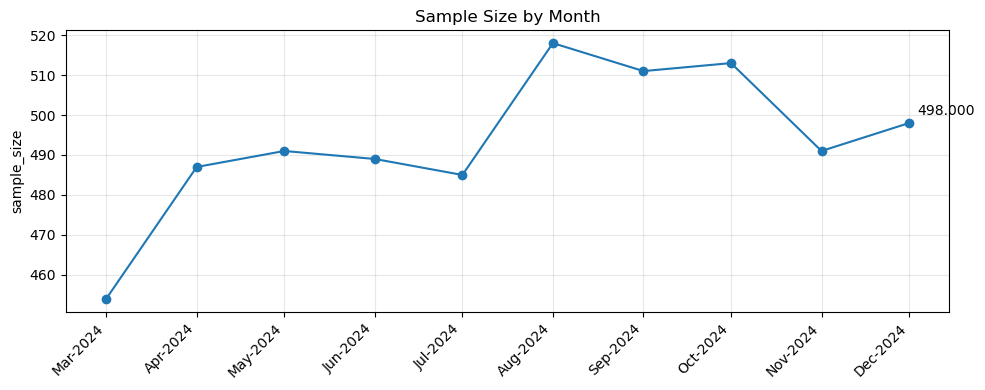

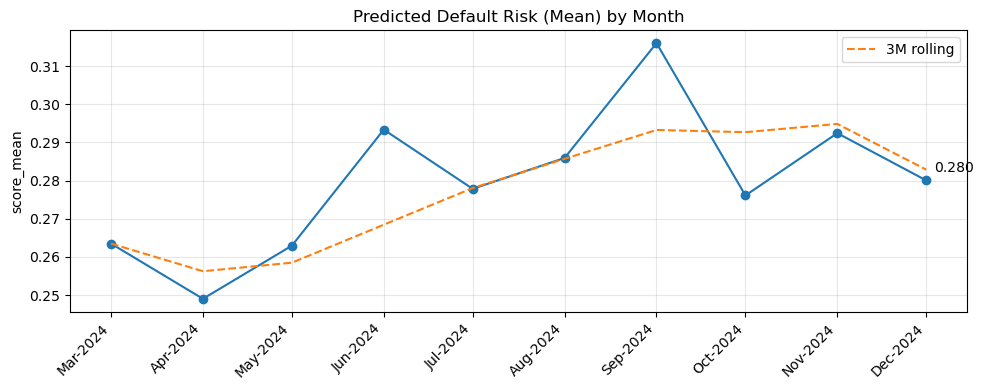

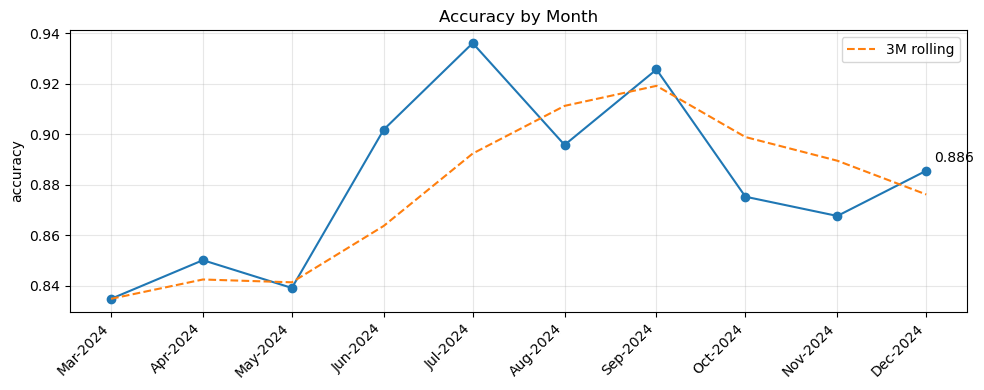

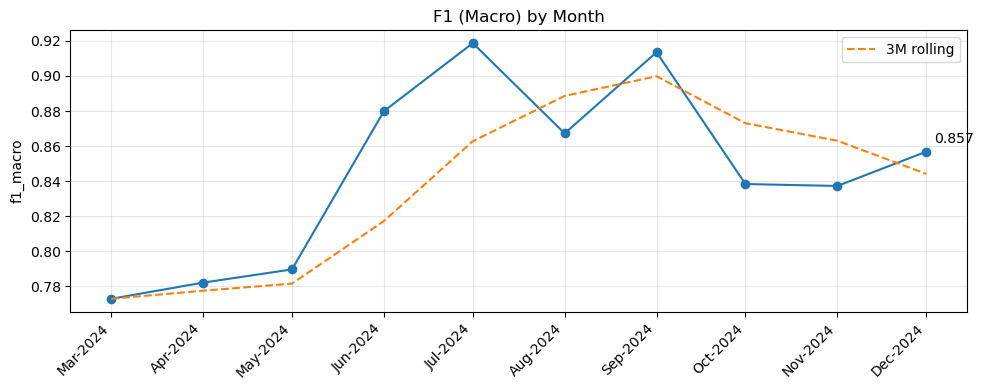

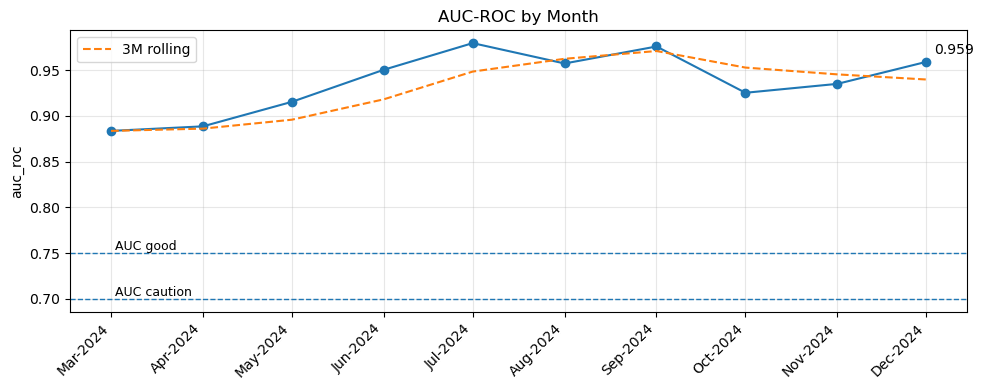

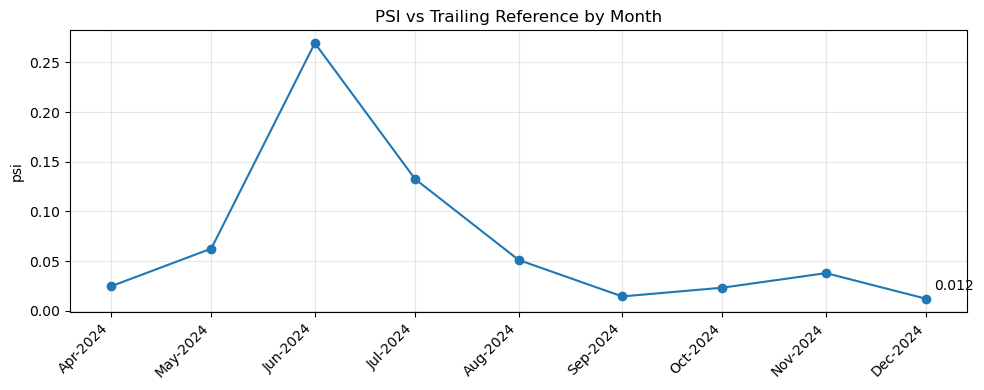

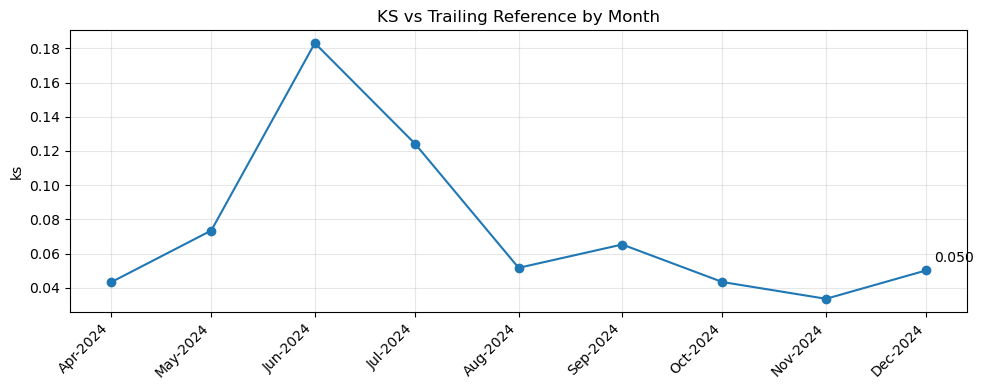

In [60]:
def _nzcol(df, col):
    if col not in df.columns:
        return None
    s = pd.to_numeric(df[col], errors="coerce")
    if s.notna().sum() == 0:
        return None
    df[col] = s
    return s

def _polish_axes(ax, title, ylabel):
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

def plot_metric_inline(df, xcol, ycol, title, ylabel, hlines=None, show_rolling=True):
    # one chart per call
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(df[xcol], df[ycol], marker='o')
    if show_rolling and ycol in {"auc_roc","accuracy","f1_macro","score_mean"}:
        roll = pd.Series(df[ycol]).rolling(3, min_periods=1).mean()
        ax.plot(df[xcol], roll, linestyle='--', label='3M rolling')
        ax.legend(loc='best')
    if hlines:
        for y, lbl in hlines:
            ax.axhline(y, linestyle='--', linewidth=1)
            ax.text(df[xcol].iloc[0], y, f" {lbl}", va='bottom', fontsize=9)
    ax.annotate(f"{df[ycol].iloc[-1]:.3f}",
                (df[xcol].iloc[-1], df[ycol].iloc[-1]),
                xytext=(6, 6), textcoords="offset points")
    _polish_axes(ax, title, ylabel)
    fig.tight_layout()
    plt.show()

# ---- Plot what exists ----
if _nzcol(monthly, "sample_size") is not None:
    plot_metric_inline(monthly, "month", "sample_size",
                       "Sample Size by Month", "sample_size",
                       show_rolling=False)

if _nzcol(monthly, "score_mean") is not None:
    plot_metric_inline(monthly, "month", "score_mean",
                       "Predicted Default Risk (Mean) by Month", "score_mean")

if _nzcol(monthly, "accuracy") is not None:
    plot_metric_inline(monthly, "month", "accuracy",
                       "Accuracy by Month", "accuracy")

if _nzcol(monthly, "f1_macro") is not None:
    plot_metric_inline(monthly, "month", "f1_macro",
                       "F1 (Macro) by Month", "f1_macro")

AUC_CAUTION, AUC_GOOD = 0.70, 0.75
if _nzcol(monthly, "auc_roc") is not None:
    plot_metric_inline(monthly, "month", "auc_roc",
                       "AUC-ROC by Month", "auc_roc",
                       hlines=[(AUC_CAUTION, "AUC caution"), (AUC_GOOD, "AUC good")])

if _nzcol(monthly, "psi_vs_trailing") is not None:
    plot_metric_inline(monthly, "month", "psi_vs_trailing",
                       "PSI vs Trailing Reference by Month", "psi",
                       show_rolling=False)

if _nzcol(monthly, "ks_vs_trailing") is not None:
    plot_metric_inline(monthly, "month", "ks_vs_trailing",
                       "KS vs Trailing Reference by Month", "ks",
                       show_rolling=False)
